# Bayesian Networks in Probabilistic Machine Learning

## Introduction
This notebook illustrates the concept of **Bayesian Networks** using the **pgmpy** package. We will:
1. Define a Bayesian Network structure.
2. Specify conditional probability distributions (CPDs) with detailed explanations.
3. Validate the model.
4. Visualize the Bayesian network.
5. Perform inference to compute probabilities of fire given sensor readings.

---


## Step 1: Import Required Libraries
We start by importing the necessary libraries for building and visualizing Bayesian networks.


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination


/Users/zp25hk/Documents/github/andresmasegosa/2025-PhD-Course-PML/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/zp25hk/Documents/github/andresmasegosa/2025-PhD-Course-PML/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Step 2: Define the Bayesian Network Structure
A Bayesian Network is a **directed acyclic graph (DAG)** where:
- **Nodes represent random variables** (e.g., Fire, Temperature, Smoke, and Sensors).
- **Edges represent probabilistic dependencies** between variables. If there is an edge from node A to node B, it means that A has a direct influence on B.

The network structure captures **causal relationships** between events. In our case:
- **Fire** is the root cause, influencing both **Temperature** and **Smoke**.
- **Temperature** affects three independent temperature sensors (**T1, T2, T3**).
- **Smoke** affects a single smoke sensor (**S1**).

This structure is **encoded using directed edges**, where each tuple `(A, B)` means "A influences B." 
We define the network in `pgmpy` as follows:

<center>
<img src="https://github.com/PGM-Lab/2025-PhD-Course-PML/raw/main/Day1/notebooks/bn1.png" alt="Drawing" width=300 >
</center>

In [2]:
# Define Bayesian Network structure
model = BayesianNetwork([
    ('Fire', 'Temp'),  # Fire influences Temperature
    ('Fire', 'Smoke'),  # Fire influences Smoke
    ('Temp', 'T1'),  # Temperature influences sensor T1
    ('Temp', 'T2'),  # Temperature influences sensor T2
    ('Temp', 'T3'),  # Temperature influences sensor T3
    ('Smoke', 'S1')   # Smoke influences sensor S1
])


## Step 3: Define Conditional Probability Distributions (CPDs)
Each node in the network requires a probability distribution. 
- The **root node** (Fire) has a prior probability distribution, as it has no parents.
- The **other nodes** (Temp, Smoke, T1, T2, T3, S1) have conditional probability distributions (CPDs) based on their parent nodes.

### Defining the Prior Probability Distribution
The node **Fire** is a binary variable (Fire = {0,1}). Since fires are relatively rare events, we assume:
- 99% probability that there is **no fire** (`Fire=0`).
- 1% probability that there **is a fire** (`Fire=1`).

This prior is based on expert knowledge that fires are rare but still possible.


In [3]:
# Define CPD for Fire (prior probability)
cpd_fire = TabularCPD(variable='Fire', variable_card=2, values=[[0.99], [0.01]])


### Defining Conditional Probability Distributions (CPDs)

#### Temperature given Fire
The **Temperature (Temp)** variable depends on **Fire**. Based on expert knowledge, we assume:
- If **no fire** (`Fire=0`), the probability of normal temperature is **95%**, and a high temperature due to other causes is **5%**.
- If there **is a fire** (`Fire=1`), the probability of high temperature is much higher (**80%**), but still, in some cases (e.g., fire just started), the temperature may remain normal (**20%**).


In [4]:
cpd_temp = TabularCPD(variable='Temp', variable_card=2, 
                       values=[[0.95, 0.2], [0.05, 0.8]], 
                       evidence=['Fire'], evidence_card=[2])


#### Smoke given Fire
The **Smoke** variable is another direct consequence of fire. Based on fire dynamics, we assume:
- If **no fire** (`Fire=0`), the probability of detecting smoke is **only 2%**, possibly due to external sources (pollution, steam, etc.).
- If there **is a fire** (`Fire=1`), the probability of smoke is very high (**90%**), but not absolute, as some fires (e.g., electrical fires) may produce little smoke.


In [5]:
cpd_smoke = TabularCPD(variable='Smoke', variable_card=2, 
                        values=[[0.98, 0.1], [0.02, 0.9]], 
                        evidence=['Fire'], evidence_card=[2])


#### Sensor Readings given Temperature
We model three independent temperature sensors **T1, T2, and T3** that depend on **Temp**:
- If **temperature is normal** (`Temp=0`), the sensors correctly read normal temperature **90%** of the time but have a **10%** chance of error.
- If **temperature is high** (`Temp=1`), the sensors detect it with **80%** accuracy but still have **20%** false negatives due to sensor faults.

These values represent standardized sensor reliability rates across all temperature sensors.


In [6]:
cpd_t1 = TabularCPD(variable='T1', variable_card=2, 
                     values=[[0.9, 0.2], [0.1, 0.8]], 
                     evidence=['Temp'], evidence_card=[2])

cpd_t2 = TabularCPD(variable='T2', variable_card=2, 
                     values=[[0.9, 0.2], [0.1, 0.8]], 
                     evidence=['Temp'], evidence_card=[2])

cpd_t3 = TabularCPD(variable='T3', variable_card=2, 
                     values=[[0.9, 0.2], [0.1, 0.8]], 
                     evidence=['Temp'], evidence_card=[2])


#### Smoke Sensor Reading given Smoke
The **S1 smoke sensor** depends on the **Smoke** variable:
- If **no smoke** (`Smoke=0`), it correctly reads no smoke **90%** of the time but has a **10%** false positive rate.
- If **smoke is present** (`Smoke=1`), it detects it **80%** of the time, with a **20%** chance of failure.

These values reflect real-world sensor imperfections due to environmental noise and hardware reliability.


In [7]:
cpd_s1 = TabularCPD(variable='S1', variable_card=2, 
                     values=[[0.9, 0.2], [0.1, 0.8]], 
                     evidence=['Smoke'], evidence_card=[2])


## Step 4: Add CPDs to the Model
Now that we have defined the CPDs, we add them to our Bayesian Network.


In [8]:
# Add CPDs to the model
model.add_cpds(cpd_fire, cpd_temp, cpd_smoke, cpd_t1, cpd_t2, cpd_t3, cpd_s1)


## Step 5: Validate the Model
Before proceeding further, we check whether the Bayesian Network is valid.


In [9]:
# Verify if the model is valid
print("Model Valid:", model.check_model())


Model Valid: True


## Step 6: Visualizing the Bayesian Network
We visualize the structure of the Bayesian Network using the **networkx** library.


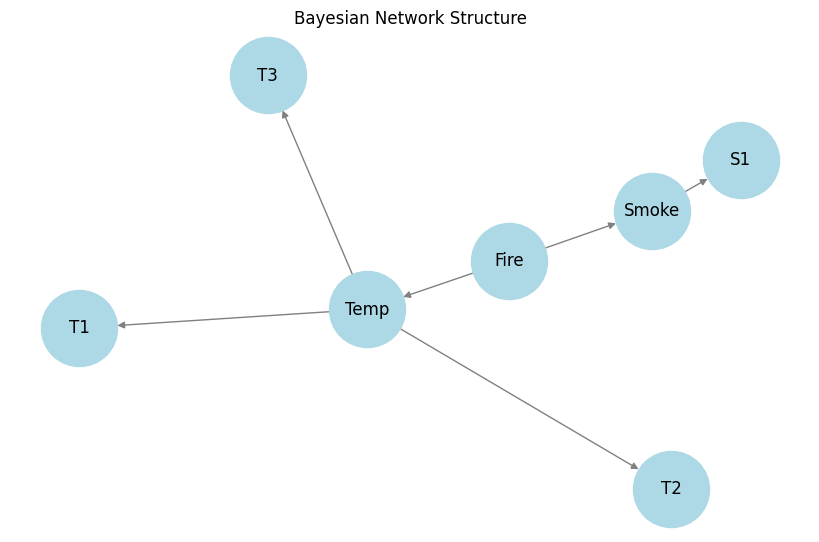

In [10]:
# Visualizing the Bayesian Network
plt.figure(figsize=(8, 5))
G = nx.DiGraph()
G.add_edges_from(model.edges())
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=12)
plt.title("Bayesian Network Structure")
plt.show()


## Step 7: Observing the Impact of Evidence on Fire Probability
One of the main advantages of Bayesian Networks is that they allow for probabilistic **inference**, meaning we can update our beliefs as we receive new evidence.

We will now examine how the probability of **Fire** (`P(Fire=1)`) changes as more evidence accumulates.

### **Initial Probability of Fire (No Evidence)**
Before introducing any evidence, we compute the baseline probability of fire:


In [11]:
# Perform inference
inference = VariableElimination(model)
prob_fire_no_evidence = inference.query(variables=['Fire'])
print("P(Fire) with no evidence:", prob_fire_no_evidence)


P(Fire) with no evidence: +---------+-------------+
| Fire    |   phi(Fire) |
+=========+=============+
| Fire(0) |      0.9900 |
+---------+-------------+
| Fire(1) |      0.0100 |
+---------+-------------+


### **Case 1: Evidence from One Temperature Sensor (T1=1)**
If a single temperature sensor (`T1`) detects a high temperature (`T1=1`), the probability of **Fire** increases.

Since sensors are not 100% reliable, we do not immediately conclude there is a fire, but we **update our belief**.


In [12]:
prob_fire_given_t1 = inference.query(variables=['Fire'], evidence={'T1': 1})
print("P(Fire | T1=1):", prob_fire_given_t1)


P(Fire | T1=1): +---------+-------------+
| Fire    |   phi(Fire) |
+=========+=============+
| Fire(0) |      0.9529 |
+---------+-------------+
| Fire(1) |      0.0471 |
+---------+-------------+


### **Case 2: Evidence from Smoke Sensor (S1=1)**
Now, let's assume that in addition to the temperature sensor detecting high temperature, the smoke sensor (`S1`) also detects smoke (`S1=1`).

Since smoke is a **stronger** indicator of fire than just high temperature, we expect the probability of fire to increase further.


In [13]:
prob_fire_given_s1 = inference.query(variables=['Fire'], evidence={'S1': 1})
print("P(Fire | S1=1):", prob_fire_given_s1)


P(Fire | S1=1): +---------+-------------+
| Fire    |   phi(Fire) |
+=========+=============+
| Fire(0) |      0.9392 |
+---------+-------------+
| Fire(1) |      0.0608 |
+---------+-------------+


### **Case 3: Multiple Temperature Sensors and Smoke Detection**
If multiple temperature sensors detect high temperature **and** smoke is present, this provides strong evidence for fire.

We set evidence:
- `T1=1` (high temperature detected by sensor T1)
- `T2=1` (high temperature detected by sensor T2)
- `S1=1` (smoke detected)

This should significantly increase the probability of fire.


In [14]:
prob_fire_given_t1_t2_s1 = inference.query(variables=['Fire'], evidence={'T1': 1, 'T2': 1, 'S1': 1})
print("P(Fire | T1=1, T2=1, S1=1):", prob_fire_given_t1_t2_s1)


P(Fire | T1=1, T2=1, S1=1): +---------+-------------+
| Fire    |   phi(Fire) |
+=========+=============+
| Fire(0) |      0.5552 |
+---------+-------------+
| Fire(1) |      0.4448 |
+---------+-------------+


### **Case 4: All Sensors Indicate Abnormal Readings**
In the strongest case, all temperature sensors and the smoke sensor detect abnormal readings:
- `T1=1`
- `T2=1`
- `T3=1`
- `S1=1`

Since all sensors provide independent confirmations of abnormal conditions, the probability of fire should approach 1 (certainty).


In [15]:
prob_fire_given_all_sensors = inference.query(variables=['Fire'], evidence={'T1': 1, 'T2': 1, 'T3': 1, 'S1': 1})
print("P(Fire | T1=1, T2=1, T3=1, S1=1):", prob_fire_given_all_sensors)


P(Fire | T1=1, T2=1, T3=1, S1=1): +---------+-------------+
| Fire    |   phi(Fire) |
+=========+=============+
| Fire(0) |      0.5004 |
+---------+-------------+
| Fire(1) |      0.4996 |
+---------+-------------+


## Step 8: Observations and Conclusions
- **Single sensor evidence** (e.g., `T1=1`) increases `P(Fire)`, but not dramatically.
- **Smoke detection (`S1=1`)** increases `P(Fire)` more than a single temperature reading.
- **Combining evidence from multiple sensors** leads to a much stronger belief in the presence of a fire.
- **When all sensors indicate abnormal readings**, the probability of fire becomes almost certain (`P(Fire) ≈ 1`).

This step-by-step approach demonstrates how Bayesian Networks allow us to continuously update probabilities as more evidence is introduced, making them highly useful for real-world decision-making in uncertain environments.


## Exercise 1: Exploring the Impact of Sensor Reliability

In this exercise, you will investigate how the reliability of sensors affects the final probabilities in our fire detection system. This will help you understand the relationship between sensor quality and system performance.

### Task Description

1. **Modify Sensor Reliability**:
   - Currently, temperature sensors (T1, T2, T3) have reliability around 70-80% for detecting high temperature (`Temp=1`)
   - The smoke sensor (S1) has 80% reliability for detecting smoke (`Smoke=1`)
   - Create new CPDs with different reliability values:
     * Try a "high reliability" scenario (90-95% accuracy)
     * Try a "low reliability" scenario (50-60% accuracy)

2. **Questions to Answer**:
   a) How does the probability of fire change with a single sensor reading when using:
      - High reliability sensors?
      - Low reliability sensors?
   
   b) How many sensors need to show positive readings to reach a 95% probability of fire in each scenario?
   
   c) What happens when sensors disagree (some positive, some negative) in each reliability scenario?


## Extended Model: Adding Environmental and Human Factors

In real-world scenarios, fire detection systems operate in complex environments where multiple factors can influence sensor readings. Let's extend our Bayesian network to include two important factors:

1. **Season**: Affects ambient temperature
2. **Presence of Cigarette**: Another potential source of smoke

### Extending the Network Structure

We'll modify our Bayesian network to include these new variables. This extension demonstrates how Bayesian networks can be incrementally enhanced to capture more complex real-world scenarios.

<center>
<img src="https://github.com/PGM-Lab/2025-PhD-Course-PML/raw/main/Day1/notebooks/bn2.png" alt="Drawing" width=300 >
</center>

In [16]:
# Define extended Bayesian Network structure
extended_model = BayesianNetwork([
    ('Fire', 'Temp'),      # Fire influences Temperature
    ('Season', 'Temp'),    # Season also influences Temperature
    ('Fire', 'Smoke'),     # Fire influences Smoke
    ('Cigarette', 'Smoke'),# Cigarette influences Smoke
    ('Temp', 'T1'),        # Temperature influences sensor T1
    ('Temp', 'T2'),        # Temperature influences sensor T2
    ('Temp', 'T3'),        # Temperature influences sensor T3
    ('Smoke', 'S1')        # Smoke influences sensor S1
    ('Smoke', 'S2')        # Smoke influences sensor S2
])


<>:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
/var/folders/dy/p06tnkrj5gx6y73ndgxp5xdc0000gq/T/ipykernel_26440/2785834428.py:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('Smoke', 'S1')        # Smoke influences sensor S1
/var/folders/dy/p06tnkrj5gx6y73ndgxp5xdc0000gq/T/ipykernel_26440/2785834428.py:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('Smoke', 'S1')        # Smoke influences sensor S1
/var/folders/dy/p06tnkrj5gx6y73ndgxp5xdc0000gq/T/ipykernel_26440/2785834428.py:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('Smoke', 'S1')        # Smoke influences sensor S1
/var/folders/dy/p06tnkrj5gx6y73ndgxp5xdc0000gq/T/ipykernel_26440/2785834428.py:10: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('Smoke', 'S1')        # Smoke influence

TypeError: 'tuple' object is not callable

### Defining New CPDs

#### 1. Season Prior Probability
We model seasons as {Winter=0, Summer=1}, with equal probability for simplicity:


In [57]:
cpd_season = TabularCPD(variable='Season', variable_card=2,
                        values=[[0.5],    # P(Winter)
                               [0.5]])    # P(Summer)


#### 2. Cigarette Prior Probability
We model the presence of cigarette smoking nearby as a binary variable:


In [58]:
cpd_cigarette = TabularCPD(variable='Cigarette', variable_card=2,
                           values=[[0.7],    # P(No cigarette)
                                  [0.3]])    # P(Cigarette present)


#### 3. Modified Temperature CPD
Now temperature depends on both Fire AND Season. This creates a more complex CPD with 4 combinations:
- Winter (0) & No Fire (0)
- Winter (0) & Fire (1)
- Summer (1) & No Fire (0)
- Summer (1) & Fire (1)


In [59]:
# Temperature CPD with two parents: Fire and Season
cpd_temp_extended = TabularCPD(
    variable='Temp',
    variable_card=2,
    values=[
        # Fire=0        Fire=1
        # S=0   S=1     S=0   S=1
        [0.95, 0.20,    0.30, 0.05],  # Temp = Normal
        [0.05, 0.80,    0.70, 0.95]   # Temp = High
    ],
    evidence=['Fire', 'Season'],
    evidence_card=[2, 2]
)


The values in this CPD represent:
- P(Temp=normal | Winter, No Fire) = 0.95  # Most likely normal in winter without fire
- P(Temp=normal | Summer, No Fire) = 0.20  # Less likely normal in summer without fire
- P(Temp=normal | Winter, Fire) = 0.30     # Some chance of normal temp with fire in winter
- P(Temp=normal | Summer, Fire) = 0.05     # Very unlikely normal with fire in summer

#### 4. Modified Smoke CPD
Similarly, smoke now depends on both Fire AND Cigarette:


In [60]:
# Smoke CPD with two parents: Fire and Cigarette
cpd_smoke_extended = TabularCPD(
    variable='Smoke',
    variable_card=2,
    values=[
        # Fire=0        Fire=1
        # C=0   C=1     C=0   C=1
        [0.98, 0.60,    0.10, 0.05],  # Smoke = No
        [0.02, 0.40,    0.90, 0.95]   # Smoke = Yes
    ],
    evidence=['Fire', 'Cigarette'],
    evidence_card=[2, 2]
)


The values represent:
- P(Smoke=no | No Fire, No Cigarette) = 0.98  # Very likely no smoke
- P(Smoke=no | No Fire, Cigarette) = 0.60     # Might be no smoke even with cigarette
- P(Smoke=no | Fire, No Cigarette) = 0.10     # Unlikely no smoke with fire
- P(Smoke=no | Fire, Cigarette) = 0.05        # Very unlikely no smoke with both



Let us add a new smoke sensor S2

In [ ]:
cpd_s2 = TabularCPD(variable='S2', variable_card=2, 
                     values=[[0.9, 0.2], [0.1, 0.8]], 
                     evidence=['Smoke'], evidence_card=[2])


### Example: Using the Extended Model

Let's see how these new factors affect our inference:

In [61]:
# Create and verify extended model
extended_model.add_cpds(cpd_fire, cpd_season, cpd_cigarette, 
                       cpd_temp_extended, cpd_smoke_extended,
                       cpd_t1, cpd_t2, cpd_t3, cpd_s1, cpd_s2)

# Initialize inference
extended_inference = VariableElimination(extended_model)

# Query 1: Probability of Fire given high temperature in summer
prob_fire_summer_temp = extended_inference.query(
    variables=['Fire'],
    evidence={'Season': 1, 'T1': 1}
)
print("P(Fire | Summer, T1=High):\n", prob_fire_summer_temp)

# Query 2: Probability of Fire given smoke and cigarette
prob_fire_smoke_cigarette = extended_inference.query(
    variables=['Fire'],
    evidence={'S1': 1, 'Cigarette': 1}
)
print("P(Fire | Smoke=Yes, Cigarette=Yes):\n", prob_fire_smoke_cigarette)


P(Fire | Summer, T1=High):
 +---------+-------------+
| Fire    |   phi(Fire) |
+=========+=============+
| Fire(0) |      0.9884 |
+---------+-------------+
| Fire(1) |      0.0116 |
+---------+-------------+
P(Fire | Smoke=Yes, Cigarette=Yes):
 +---------+-------------+
| Fire    |   phi(Fire) |
+=========+=============+
| Fire(0) |      0.9801 |
+---------+-------------+
| Fire(1) |      0.0199 |
+---------+-------------+


### Key Insights from the Extended Model

1. **Context Matters**:
   - High temperature in summer is less indicative of fire than in winter
   - Smoke with known cigarette presence is less alarming than without

2. **Multiple Causes**:
   - The model now captures how different causes can lead to the same observation
   - This helps reduce false alarms by considering alternative explanations

3. **Probabilistic Reasoning**:
   - The network automatically weighs different pieces of evidence
   - It considers both direct causes (fire) and alternative explanations (season, cigarettes)

### Exercise Extension

Consider these additional questions:
1. How does the season affect the number of sensors needed to confidently detect a fire?
2. What is the optimal sensor threshold for fire detection in summer vs winter?
3. How would you modify the model to account for time of day (which might affect both temperature and cigarette probability)?
